In [1]:
%pylab inline
%autosave 25

import umap
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Get some data

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

In [3]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

df_features.head()

rows: 22,172, columns: 14,730


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
58,204,Q99VQ4,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
97,204,EDT84149,0,3.936758,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
98,204,AAX80043,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
126,204,P0C6X7,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
136,8549,P08659,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


### UMAP

pip install umap-learn

reference material:

* [How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)
* [How to Use UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
* [Basic UMAP Parameters](https://umap-learn.readthedocs.io/en/latest/parameters.html)
* [UMAP API Guide](https://umap-learn.readthedocs.io/en/latest/api.html)
* [UMAP for Supervised Dimension Reduction and Metric Learning](https://umap-learn.readthedocs.io/en/latest/supervised.html)

In [4]:
cols_to_exclude = ['cid', 'pid', 'activity']

# fingerprint columns
df = pd.read_csv(data_loc+'drug_features/fingerprints.csv', index_col=0, nrows=0)
cols_to_exclude = cols_to_exclude + df.columns.tolist()
del df

# binding-site columns
df = pd.read_csv(data_loc+'protein_features/binding_sites_v1.0.csv', index_col=0, nrows=0)
cols_to_exclude = cols_to_exclude + df.columns.tolist()
del df

# some columns have already been dropped in previous processing, e.g. removal of zero-variance columns
cols_to_exclude = df_features.columns.intersection(cols_to_exclude)

print('{:,} don\'t need to be scaled'.format(len(cols_to_exclude)))

cols_to_keep = df_features.drop(cols_to_exclude, axis=1).columns.tolist()

print('{:,} do need to be scaled'.format(len(cols_to_keep)))

12,405 don't need to be scaled
2,325 do need to be scaled


#### Scale the centroid-sampled data and retrain umap (supervised)

In [5]:
# scale only the cols_to_keep
scaler = StandardScaler()
features = df_features[cols_to_keep]
df_features[cols_to_keep] = scaler.fit_transform(features.values)
del features

In [6]:
df_features.drop(columns=['cid', 'pid'], axis=1, inplace=True)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine')
embedding = reducer.fit_transform(df_features.values, y=df_features['activity'].values)

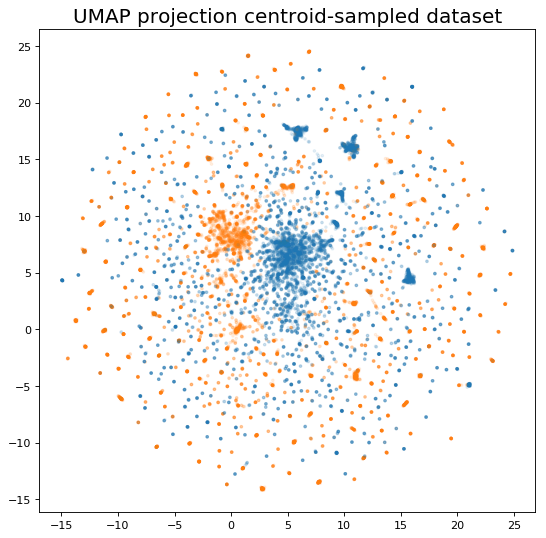

In [7]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection centroid-sampled dataset', fontsize=18);

#### fit scaled, full dataset to umap

Scaled data set from the dbscan.ipynb notebook.

In [8]:
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
df_all_features = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_all_features), len(df_all_features.columns)))
store.close()

rows: 184,063, columns: 14,730


In [9]:
df_dropped = df_all_features[['cid', 'pid', 'activity']]

In [ ]:
df_all_features.drop(columns=['cid', 'pid', 'activity'], axis=1, inplace=True)
embedding_full = reducer.transform(df_all_features.values)

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_full[:, 0], embedding_full[:, 1], c=[sns.color_palette()[x] for x in df_dropped.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('supervised UMAP projection centroid-sampled dataset', fontsize=18);

#### superimpose both embeddings

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.scatter(embedding_full[:, 0], embedding_full[:, 1], c=[sns.color_palette()[x] for x in df_dropped.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection full, scaled dataset', fontsize=18);

#### Fit scaled, centroid-based sample data (unsupervised)

In [ ]:
X = df_features.drop(columns=['activity'], axis=1).values
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine')
embedding_unsup = reducer.fit_transform(X)

In [ ]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('unsupervised UMAP projection centroid-sampled dataset', fontsize=18);

## Check column variance

How many columns have zero variance? We can drop those.

In [24]:
no_var_cols = [col for col in df_features.columns if df_features[col].nunique() == 1]

len(no_var_cols)

0

In [ ]:
var_cols = [col for col in df_features.columns if df_features[col].nunique() > 1]
df_novar_cols_dropped = df_features[var_cols].copy()

print('Dropped {:,} columns that have zero variance.'.format(len(df_features.columns)-len(var_cols)))

print('rows: {:,}, columns: {:,}'.format(len(df_novar_cols_dropped), len(df_novar_cols_dropped.columns)))

## Scale the data

In [ ]:
df_features.drop(columns=['cid', 'pid', 'activity'], inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features.values)

In [ ]:
scaled_data.T[1000].mean()

## Find highly correlated columns

In [ ]:
df_scaled = pd.DataFrame(scaled_data, columns=df_features.columns)

In [ ]:
df_scaled.head()

In [ ]:
a = [0, 1, 2, 3, 4, 5, 6]

res = [(x, y) for i,x in enumerate(a) for j,y in enumerate(a) if i > j]

res

In [ ]:
b = [1,1,2,3,4,5,6]
np.corrcoef(a, b)[0][1]

In [ ]:
from IPython.display import display, clear_output

cols = df_scaled.columns.tolist()

corr_cols = []

def func(x, y):
    i = len(corr_cols)
    clear_output(wait=True)
    display('processed column {:,}'.format(i))
        
    corr_cols.append(x)
    return (x, y)
    

out = [func(x, y) for i,x in enumerate(cols) for j,y in enumerate(cols) if i > j and 
       np.corrcoef(df_scaled[x], df_scaled[y])[0][1] > 0.9]

In [ ]:
len(out)

## Find correlated columns within the fingerpirnt data

In [4]:
df_fingerprints = pd.read_csv(data_loc+'drug_features/fingerprints.csv', index_col=0)

print('Number of rows: {:,}\n'.format(len(df_fingerprints)))
print('Number of columns: {:,}\n'.format(len(df_fingerprints.columns)))

Number of rows: 91,756

Number of columns: 4,096



In [5]:
num_cols = len(df_fingerprints.columns)
num_pairwise_ops = (num_cols**2-num_cols)/2.0
num_pairwise_ops

8386560.0

In [ ]:
# See which correlation method is fastest:

In [ ]:
%%timeit
np.corrcoef(df_fingerprints['1947'], df_fingerprints['389'])

### See https://stackoverflow.com/questions/33650188/efficient-pairwise-correlation-for-two-matrices-of-features

In [ ]:
fingerprint_cols = df_fingerprints.columns.tolist()
df_sampled_fingerprint = df_features[fingerprint_cols].sample(n=1000, random_state=23)

In [ ]:
# Get number of rows in either A or B
N = len(df_sampled_fingerprint)

def corr_func(a, b):
    A = np.array([df_sampled_fingerprint[a].values]).T
    B = np.array([df_sampled_fingerprint[b].values]).T

    # Store columnw-wise in A and B, as they would be used at few places
    sA = A.sum(0)
    sB = B.sum(0)

    # Basically there are four parts in the formula. We would compute them one-by-one
    p1 = N*np.dot(B.T,A)
    p2 = sA*sB[:,None]
    p3 = N*((B**2).sum(0)) - (sB**2)
    p4 = N*((A**2).sum(0)) - (sA**2)

    # Finally compute Pearson Correlation Coefficient as 2D array 
    pcorr = ((p1 - p2)/np.sqrt(p4*p3[:,None]))

    # Get the element corresponding to absolute argmax along the columns 
    return pcorr[np.nanargmax(np.abs(pcorr),axis=0),np.arange(pcorr.shape[1])][0]

In [ ]:
%%timeit
corr_func('1947', '389')

In [ ]:
# corr_func is faster than np.corrcoef

In [ ]:
from IPython.display import display, clear_output

cols = df_sampled_fingerprint.columns.tolist()

corr_cols = []

def func(x, y):
    i = len(corr_cols)
    clear_output(wait=True)
    display('processed column pair {:,} out of {:,}'.format(i, num_pairwise_ops))
        
    corr_cols.append(x)
    return (x, y)
    

out = [func(x, y) for i,x in enumerate(cols) for j,y in enumerate(cols) if i > j and 
       corr_func(x, y) > 0.9]

In [ ]:
# It's still really slow

In [ ]:
out

### Let's try https://deepgraph.readthedocs.io/en/latest/tutorials/pairwise_correlations.html

In [5]:
#df = pd.read_csv(data_loc+'drug_features/fingerprints.csv', index_col=0)
df = pd.read_csv(data_loc+'protein_features/binding_sites_v1.0.csv', index_col=0)

print('Number of rows: {:,}\n'.format(len(df)))
print('Number of columns: {:,}\n'.format(len(df.columns)))

Number of rows: 4,165

Number of columns: 8,481



In [6]:
# use only the rows from the sampled data set
# and only the columns from the fingerprints data
df_cols = df.columns.tolist()
cols = df_features.columns.intersection(df_cols)
df_sampled = df_features[cols]

del df
del df_features

In [7]:
df_sampled.shape

(22172, 8417)

In [ ]:
import os
from multiprocessing import Pool
import deepgraph as dg

In [9]:
# create observations
from numpy.random import RandomState
prng = RandomState(0)
n_features = len(df_sampled.columns)
n_samples = 1000

# run over a sample of the rows. Can do this multiple times and take consensus.
X = df_sampled.sample(n=n_samples, random_state=23).values.T

# whiten variables for fast parallel computation later on
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

# save in binary format
np.save(data_loc+'samples', X)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [11]:
import subprocess

# delete old correlation files
subprocess.run('rm {}correlations/*'.format(data_loc), shell=True)

CompletedProcess(args='rm ../data/FDA-COVID19_files_v1.0/correlations/*', returncode=1)

In [12]:
step_size = 5e2
n_processes = 1500

# load samples as memory-map
del X
X = np.load(data_loc+'samples.npy', mmap_mode='r')

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

# connector function to compute pairwise pearson correlations
# index_s and index_t are equal length arrays of indices for pairwise correlation
def corr(index_s, index_t):
    features_s = X[index_s].T
    features_t = X[index_t].T
    
    c = 1./(n_samples - 1)
    cov_xy = c * np.dot(features_s.T, features_t)
    var_x = c * np.sum(features_s**2, axis=0)
    var_y = c * np.sum(features_t**2, axis=0)
    corrcoef_xy = cov_xy / np.sqrt(var_x[:, None] * var_y[None,:])
    corr = np.diag(corrcoef_xy)
    
    del cov_xy
    del var_x
    del var_y
    del corrcoef_xy
    
    #if 1947 in index_t:
    #    print('corrcoef_xy shape: {}, index_s shape: {}, index_t shape: {}'.format(corrcoef_xy.shape, index_s.shape, index_t.shape))
    
    return corr
    

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# parallel computation
def create_ei(i):

    from_pos = pos_array[i]
    to_pos = pos_array[i+1]

    # initiate DeepGraph
    g = dg.DeepGraph(v)

    # create edges
    g.create_edges(connectors=corr, step_size=step_size,
                   from_pos=from_pos, to_pos=to_pos)

    # store edge table
    g.e.to_pickle((data_loc+'correlations/{}.pickle').format(str(i).zfill(3)))

# computation
if __name__ == '__main__':
    os.makedirs(data_loc+'correlations/', exist_ok=True)
    indices = np.arange(0, n_processes - 1)
    p = Pool()
    for _ in p.imap_unordered(create_ei, indices):
        pass

In [13]:
# store correlation values
files = os.listdir(data_loc+'correlations/')
files.sort()
store = pd.HDFStore(data_loc+'e.h5', mode='w')
for f in files:
    #print((data_loc+'correlations/{}').format(f))
    et = pd.read_pickle((data_loc+'correlations/{}').format(f))
    store.append('e', et, format='t', data_columns=True, index=False)
store.close()

In [14]:
# load correlation table
e = pd.read_hdf(data_loc+'e.h5')

In [15]:
len(e)

35418736

In [ ]:
col1 = df_fingerprints.columns.get_loc('1947')
col2 = df_fingerprints.columns.get_loc('389')

In [80]:
e.abs().max()

corr    1.0
dtype: float64

In [62]:
e.query('s == 389 and t == 1947')

,,corr
s,t,
389,1947,0.962531


In [16]:
e2 = e.abs()
len(e2[e2['corr'] > 0.9])

3301

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x28c2e4208>]],
      dtype=object)

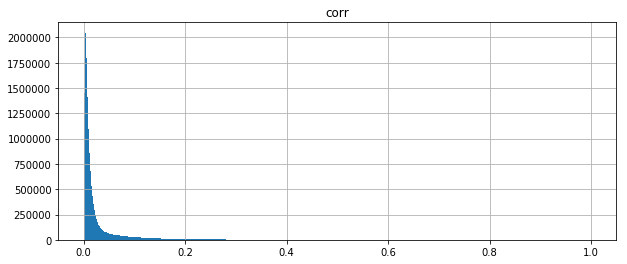

In [17]:
e.abs().hist(bins=1000, figsize=(10,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x29e0c1710>]],
      dtype=object)

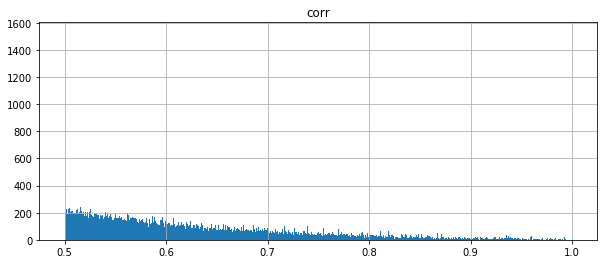

In [18]:
e2[e2['corr'] > 0.5].hist(bins=1000, figsize=(10,4))

### XY Pearson correlation

https://stackoverflow.com/questions/41538254/memory-efficient-ways-of-computing-large-correlation-matrices?rq=1

In [14]:
x = X[[1947]].T
y = X[[389]].T

samples = x.shape[0]
c = 1./(samples - 1)
cov_xy = c * np.dot(x.T, y)
var_x = c * np.sum(x**2, axis=0)
var_y = c * np.sum(y**2, axis=0)
corrcoef_xy = cov_xy / np.sqrt(var_x[:, None] * var_y[None,:])

corrcoef_xy

array([[0.9625312]])

### np.einsum for calculating pearson's correlation

https://stackoverflow.com/questions/50323786/compute-correlation-in-numpy

In [9]:
ma = np.random.random((5,6)).T
mb = np.random.random((5,6)).T
 
za = ma - ma.mean(axis=1, keepdims=True)
za /= np.sqrt(np.einsum('ij,ij->i', za, za))[:, None]
zb = mb - mb.mean(axis=1, keepdims=True)
zb /= np.sqrt(np.einsum('ij,ij->i', zb, zb))[:, None]
 
cc = np.einsum('ik,jk', za, zb)

#np.allclose(cc, np.corrcoef(ma, mb)[:5, 5:])
cc.shape

(6, 6)

In [10]:
za = ma - ma.mean(axis=1, keepdims=True)
za /= np.sqrt(np.einsum('ij,ij->i', za, za))[:, None]
cc = np.einsum('ik,jk', za, za)
cc.shape

(6, 6)

In [20]:
za

array([[ 0.41655389, -0.17400035, -0.76742633,  0.07599897,  0.44887383],
       [-0.55733007,  0.80813066, -0.01135404, -0.05843796, -0.18100859],
       [-0.51054979,  0.26521874, -0.5737303 ,  0.36262266,  0.45643869],
       [-0.47932298, -0.04737243, -0.49224991,  0.56679005,  0.45215527],
       [-0.59223603, -0.20378343,  0.58535125, -0.24316423,  0.45383243],
       [-0.48578584,  0.36408273, -0.27625728,  0.68680781, -0.28884742]])

In [11]:
cc2 = np.corrcoef(ma)

In [12]:
cc

array([[ 1.        , -0.44975089,  0.41391842,  0.43238064, -0.47522053,
        -0.13115875],
       [-0.44975089,  1.        ,  0.40158005,  0.11948098,  0.09080366,
         0.58025433],
       [ 0.41391842,  0.40158005,  1.        ,  0.92648496,  0.03145487,
         0.62028753],
       [ 0.43238064,  0.11948098,  0.92648496,  1.        ,  0.07276661,
         0.61026041],
       [-0.47522053,  0.09080366,  0.03145487,  0.07276661,  1.        ,
        -0.24629711],
       [-0.13115875,  0.58025433,  0.62028753,  0.61026041, -0.24629711,
         1.        ]])

In [13]:
cc2

array([[ 1.        , -0.44975089,  0.41391842,  0.43238064, -0.47522053,
        -0.13115875],
       [-0.44975089,  1.        ,  0.40158005,  0.11948098,  0.09080366,
         0.58025433],
       [ 0.41391842,  0.40158005,  1.        ,  0.92648496,  0.03145487,
         0.62028753],
       [ 0.43238064,  0.11948098,  0.92648496,  1.        ,  0.07276661,
         0.61026041],
       [-0.47522053,  0.09080366,  0.03145487,  0.07276661,  1.        ,
        -0.24629711],
       [-0.13115875,  0.58025433,  0.62028753,  0.61026041, -0.24629711,
         1.        ]])